In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import signal
import scipy.linalg as la
import scipy.stats as sts
from matplotlib.pyplot import *

import jax
import jax.numpy as jnp

from copy import copy

In [2]:
%matplotlib widget

I0000 00:00:1704390004.133795       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


Text(0, 0.5, 'Cross Section ($\\sigma$)')

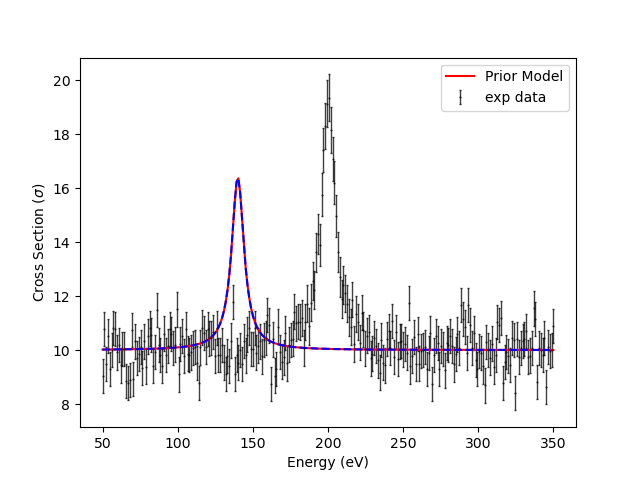

In [3]:
# Define the function using JAX NumPy
def Breit_Wigner(theta, E):
    Elam, Gg, Gn = jnp.split(theta, 3)
    xs = jnp.zeros(len(E))
    for iE, iGg, iGn in zip(Elam, Gg, Gn):
        xs += iGg * iGn / ((E - iE) ** 2 + (iGg + iGn) ** 2 / 4)
    return xs*10 + 10



idat = 250
E = np.linspace(50,350,idat)


true_theta = np.array([ 200.0,  
                        4.0,    
                        8.0,    ])
true_mod = Breit_Wigner(true_theta, E)
std = np.sqrt(true_mod)/5
sample_data = sts.norm.rvs(loc=true_mod, scale=std)
sample_cov = np.diag(np.ones(len(sample_data))*std**2)

prior_theta = np.array([140.0,#180,  
                        2.0,  #1.0, 
                        8.0  # 8.0
                        ])
prior_mod = Breit_Wigner(prior_theta,E)

figure()
# plot(x, lorentz(x, 50, 10))
errorbar(E, sample_data, yerr=np.sqrt(np.diag(sample_cov)).flatten(),
          alpha=0.75, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='exp data')
# plot(E, true_mod, label='true', color='b')
plot(E, prior_mod, label='Prior Model', color='r')


prior_theta = np.array([140.0,  
                        8.0,    
                        2.0,    ])
prior_mod = Breit_Wigner(prior_theta,E)
plot(E, prior_mod, color='b', linestyle='dashed')

# prior_theta = np.array([190.0,  
#                         20.0,    
#                         1.0,    ])
# prior_mod = Breit_Wigner(prior_theta,E)
# plot(E, prior_mod, color='r')#, linestyle='dashed')


legend()
xlabel('Energy (eV)')
ylabel(r'Cross Section ($\sigma$)')

In [4]:
G = jax.jacobian(Breit_Wigner, argnums=0)(prior_theta, E)
y_pred = Breit_Wigner(prior_theta, E)
gradient1 = -2 * (G.T@la.inv(sample_cov)@(sample_data-y_pred)) 
gradient2 = -2 * ((sample_data-y_pred).T@la.inv(sample_cov)@G) 
print(gradient1)
print(gradient2)

[ -1.3585116 -39.383118  448.1606   ]
[ -1.358513 -39.383083 448.1606  ]


In [5]:
Elam = np.linspace(100,300, 50)
Elam = np.sort(np.append(Elam, 200))
Gn = np.linspace(0.0, 15.0, 30)
Gn1 = np.linspace(0.0, 15.0, 30)

# gradient_E = np.zeros([len(Elam), len(Gn)])
chi2_map = np.zeros([len(Gn), len(Gn1)])


# for ie, e in enumerate(Elam):
for ig1, g1 in enumerate(Gn1):
    for ig, g in enumerate(Gn):

        prior_theta = np.array([193, #  180,
                                g, #  4.0,   
                                g1   #, 8.0 
                                ])
        # Compute predictions
        y_pred = Breit_Wigner(prior_theta, E)
        chi2 = (sample_data-y_pred).T @ la.inv(sample_cov) @ (sample_data-y_pred)

        # Compute the gradient of the mean squared error with L1 penalty
        # G = jax.jacobian(Breit_Wigner, argnums=0)(prior_theta, E)
        # Elam, Gg, Gn = jnp.split(prior_theta, 3)
        # grad = -2 * (G.T@la.inv(sample_cov)@(sample_data-y_pred))

        # chi2_map[ie, ig] = chi2
        chi2_map[ig, ig1] = chi2

chi2_map_norm = chi2_map/len(E)

KeyboardInterrupt: 

Text(0.5, 0, '$\\chi^2$/DOF')

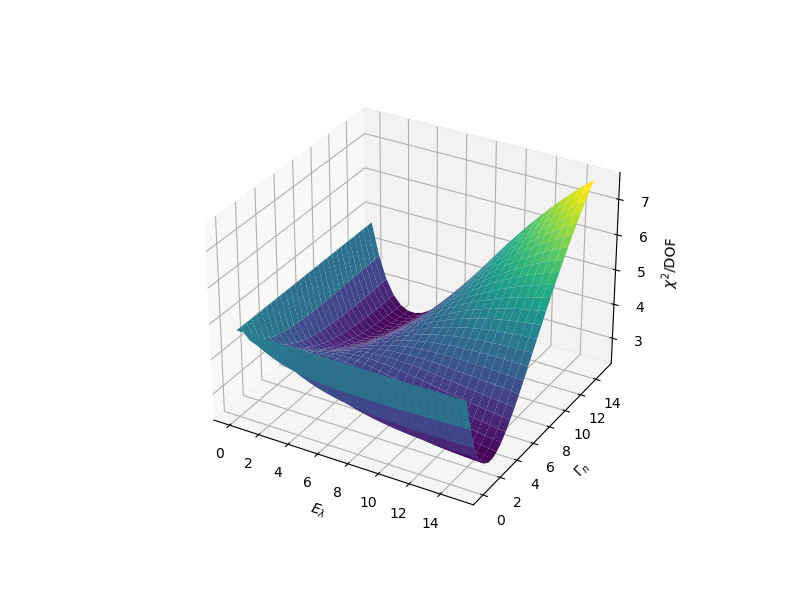

In [ ]:
# g, e = np.meshgrid(Gn, Elam)
g, e = np.meshgrid(Gn1, Gn)


fig =figure(figsize=(8,6))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=e, Y=g, Z=chi2_map_norm, cmap = 'viridis')
ax.set_xlabel(r"$E_{\lambda}$")
ax.set_ylabel(r"$\Gamma_n$")
ax.set_zlabel(r'$\chi^2$/DOF')

# Show the plot
# plt.show()

In [ ]:
chi2_map_norm.shape

(30, 30)

Text(0.5, 1.0, 'Simplest default with labels')

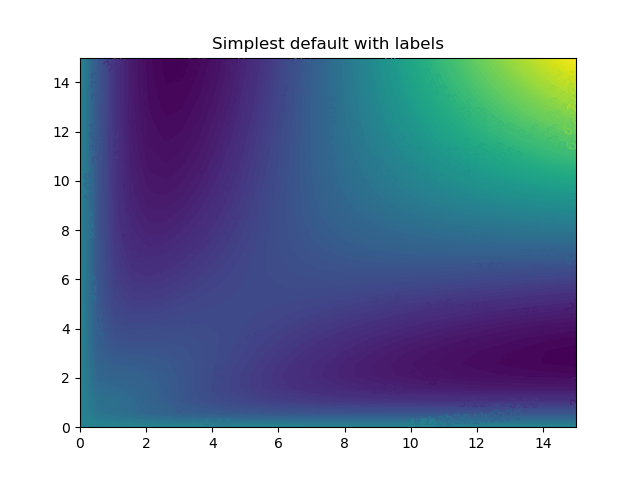

In [ ]:
# figure()
# ax = fig.add_subplot(111)
# CS = ax.contour([e, g,], chi2_map_norm)
fig, ax = subplots()
CS = ax.contourf(e, g, chi2_map_norm, levels=100)
ax.clabel(CS, inline=False, fontsize=10) #
ax.set_title('Simplest default with labels')


In [ ]:
# Gn = np.linspace(0.0, 200.0, 250)
# chi2_save = []

# for ig, g in enumerate(Gn):

#     prior_theta = np.array([200,  
#                             g,    
#                             8.0,    ])
#     # Compute predictions
#     y_pred = Breit_Wigner(prior_theta, E)
#     chi2 = (sample_data-y_pred).T @ la.inv(sample_cov) @ (sample_data-y_pred)
#     chi2_save.append(chi2)

# chi2_save_norm = np.array(chi2_save)/len(E)

In [ ]:
Elam

array([100.        , 104.08163265, 108.16326531, 112.24489796,
       116.32653061, 120.40816327, 124.48979592, 128.57142857,
       132.65306122, 136.73469388, 140.81632653, 144.89795918,
       148.97959184, 153.06122449, 157.14285714, 161.2244898 ,
       165.30612245, 169.3877551 , 173.46938776, 177.55102041,
       181.63265306, 185.71428571, 189.79591837, 193.87755102,
       197.95918367, 200.        , 202.04081633, 206.12244898,
       210.20408163, 214.28571429, 218.36734694, 222.44897959,
       226.53061224, 230.6122449 , 234.69387755, 238.7755102 ,
       242.85714286, 246.93877551, 251.02040816, 255.10204082,
       259.18367347, 263.26530612, 267.34693878, 271.42857143,
       275.51020408, 279.59183673, 283.67346939, 287.75510204,
       291.83673469, 295.91836735, 300.        ])

IndexError: index 30 is out of bounds for axis 0 with size 30

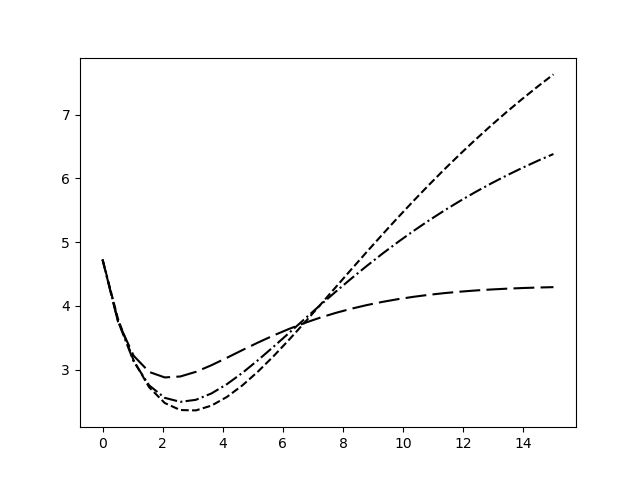

In [ ]:
figure()
markers = [(5, (10, 3)), 'dashdot', 'dashed','dotted']
for i, iE in enumerate([15, 23,29, 30]): 
    plot(Gn1, chi2_map_norm[iE, :], linestyle=markers[i], color='k', label=r'$E_{\lambda}$='+f'{round(Elam[iE],2)}')

plot(Gn1, chi2_map_norm[25, :],color='k', linestyle='solid', lw=2, label=r"True $E_{\lambda}$")
legend()
# xlabel(r"$\Gamma_n$")
xlabel(r"$\Gamma_{\gamma}$")
ylabel(r'$\chi^2$/DOF')
# xlabel(r"\Gamma_n")
# xlim(-1,80)
# title(r"Objective Function vs. $\Gamma_n$")
title(r"Objective Function vs. $\Gamma_{\gamma}$")

ValueError: x and y must have same first dimension, but have shapes (51,) and (30,)

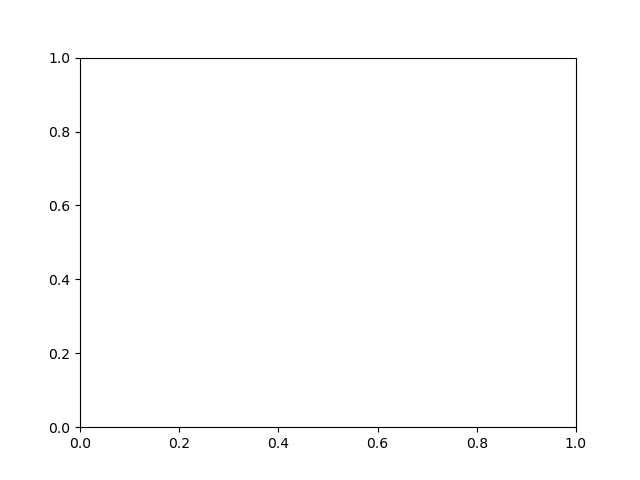

In [ ]:
markers = ['solid', 'dashdot', 'dashed','dotted']
figure()
for i,ign in enumerate([3,10,20,29]):
    plot(Elam, chi2_map[:,ign], label =f'Gn = {ign}', linestyle=markers[i], color ='k');

legend()
ylabel(r'$\chi^2$/DOF')
xlabel('Resonance Energy')

## With sammy

In [ ]:
from ATARI.sammy_interface import sammy_classes, sammy_functions, template_creator
import os
from ATARI.ModelData.particle_pair import Particle_Pair
from ATARI.ModelData.experimental_model import Experimental_Model

from ATARI.syndat.syndat_model import Syndat_Model
from ATARI.syndat.control import syndatOPT


### setup the reaction model and sample a resonance
Ta_pair = Particle_Pair(energy_range_all=[210, 230])      

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)
Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

# setup experimental transmission model
exp_model_T = Experimental_Model(title = 'trans',
                                 reaction='transmission',
                                energy_range=[210,230],
                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [613.02, 6140.23], 
                                    "chw": [102.4, 51.2],
                                    "dchw": [1.6, 1.6]})

exp_model_Y = Experimental_Model(title = 'cap',
                                 reaction='capture',
                                energy_range=[210,230],
                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [613.02, 6140.23], 
                                    "chw": [102.4, 51.2],
                                    "dchw": [1.6, 1.6]})


# calculate experimentally corrected transmission or capture yield with sammy
rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   False,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR_1"
                                         })

template_creator.make_input_template('template_T.inp', Ta_pair, exp_model_T, rto)
template_creator.make_input_template('template_Y.inp', Ta_pair, exp_model_Y, rto)
exp_model_T.template = os.path.realpath('template_T.inp')
exp_model_Y.template = os.path.realpath('template_Y.inp')

synOPT = syndatOPT(calculate_covariance=False)

syndat_T = Syndat_Model(exp_model_T,
                        options = synOPT,
                        title='trans')
syndat_Y = Syndat_Model(exp_model_Y,
                        options = synOPT,
                        title='cap')


resonance_ladder = pd.DataFrame({"E":[220    ], #, 212],
                                 "Gg":[60.0  ], #, 60],
                                 "Gn1":[20.0 ], #, 10.0],
                                 "J_ID":[1.0 ], #, 1.0]
                                 })

Ta_pair.resonance_ladder = resonance_ladder
pw_true_T = syndat_T.generate_true_experimental_objects(Ta_pair, rto, generate_pw_true_with_sammy=True)
pw_true_Y = syndat_Y.generate_true_experimental_objects(Ta_pair, rto, generate_pw_true_with_sammy=True)


std_T = np.sqrt(pw_true_T['true'].values+5)/40
pw_true_T['exp'] = sts.norm.rvs(loc = pw_true_T['true'].values, scale=std_T)
pw_true_T['exp_unc'] = np.ones(len(pw_true_T))*std_T

std_Y = np.sqrt(pw_true_Y['true'].values+5)/40
pw_true_Y['exp'] = sts.norm.rvs(loc = pw_true_Y['true'].values, scale=std_Y)
pw_true_Y['exp_unc'] = np.ones(len(pw_true_Y))*std_Y



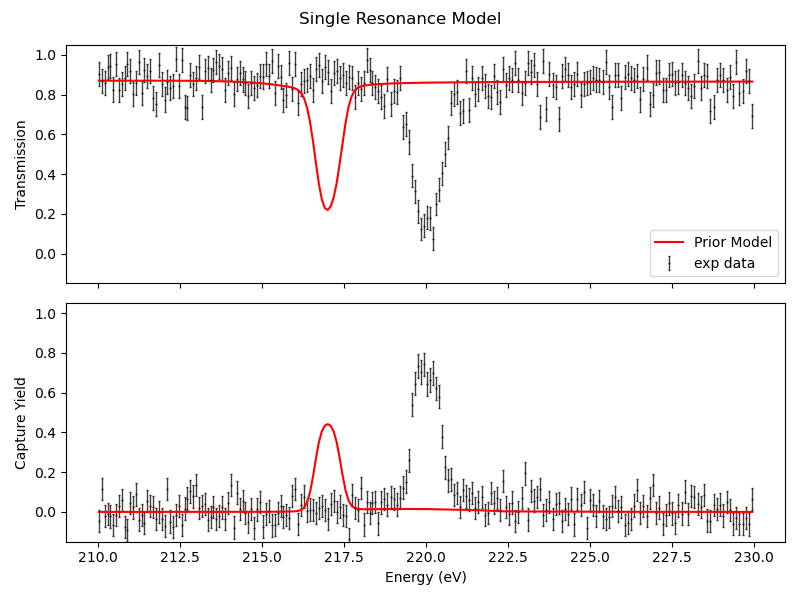

In [ ]:
resonance_ladder = pd.DataFrame({"E":   [217    ],#   220],
                                 "Gg":  [10.0   ],#  1000.0],
                                 "Gn1": [10.0    ],#   20.0],
                                 "J_ID":[1.0    ],#   1.0]
                                 })

sammyINP = sammy_classes.SammyInputDataYW(
    Ta_pair,
    resonance_ladder=resonance_ladder,
    datasets= [pw_true_T,pw_true_Y],
    experiments=[exp_model_T, exp_model_Y], 
    experimental_covariance= [{}, {}]
      
)

out = sammy_functions.run_sammy_YW(sammyINP, rto)


# print(sammyOUT_fit.chi2n)
fig, axes = subplots(2,1, figsize=(8,6), sharex=True, sharey=True)
axes[0].errorbar(pw_true_T.E, pw_true_T.exp, yerr=pw_true_T.exp_unc,
          alpha=0.75, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='exp data')

axes[1].errorbar(pw_true_Y.E, pw_true_Y.exp, yerr=pw_true_Y.exp_unc,
          alpha=0.75, fmt='.', capsize=1, markersize=1, linewidth=1, color='k', label='exp data')


axes[0].plot(out.pw[0].E, out.pw[0].theo_trans, label='Prior Model', color='r')
axes[1].plot(out.pw[1].E, out.pw[1].theo_xs, label='Prior Model', color='r')
# plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_xs, label='Fitted Model', color='b')

axes[0].legend(loc='lower right')
axes[0].set_ylim(-0.15,1.05)
axes[1].set_xlabel('Energy (eV)')
axes[0].set_ylabel(r'Transmission')
axes[1].set_ylabel(r'Capture Yield')
fig.suptitle("Single Resonance Model")

tight_layout()

In [ ]:
Elam = np.linspace(215,225, 50)
Elam = np.sort(np.append(220, Elam))

Gn_array = np.linspace(1.0, 50.0, 50)
Gg_array = np.linspace(30.0, 1000.0, 50)

width = "Gn"

if width == "Gg":
    G = Gg_array
    gfixed= 0.1
elif width == "Gn":
    G = Gn_array
    gfixed = 60.0
else:
    raise ValueError

chi2_map = np.zeros([len(Elam), len(G)])
for ie, e in enumerate(Elam):
    for ig, g in enumerate(G):

        if width == "Gg":
            gg = g
            gn = gfixed
        elif width == "Gn":
            gn = g 
            gg = gfixed
        else:
            raise ValueError

        resonance_ladder = pd.DataFrame({"E":   [e    ],#   220],
                                         "Gg":  [gg   ],#  1000.0],
                                         "Gn1": [gn    ],#   20.0],
                                         "J_ID":[1.0    ],#   1.0]
                                        })

        sammyINP.resonance_ladder = resonance_ladder
        out = sammy_functions.run_sammy_YW(sammyINP, rto)
        chi2_map[ie,ig] = np.sum(out.chi2n)
        

In [ ]:
np.argwhere(Elam==220.0).item()

25

Text(0.5, 0, '$\\chi^2$/DOF')

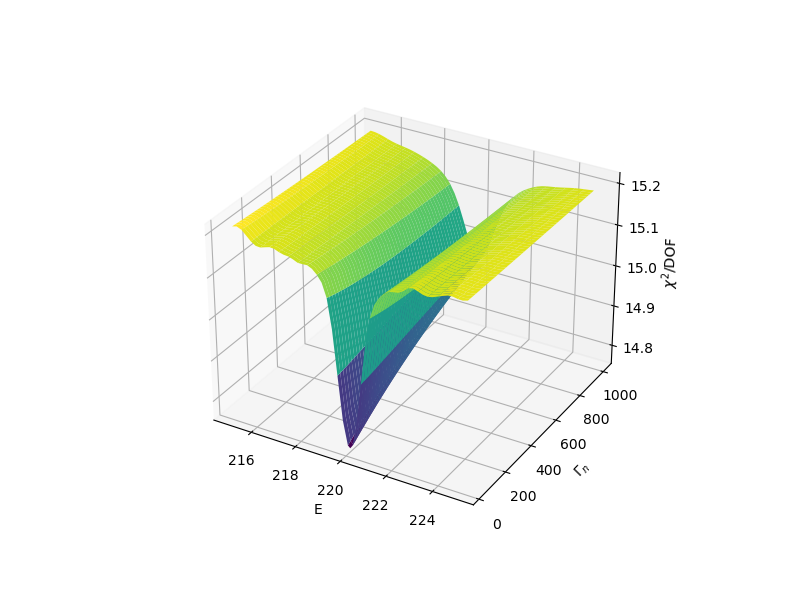

In [ ]:


g, e = np.meshgrid(G, Elam)

fig =figure(figsize=(8,6))

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X=e, Y=g, Z=chi2_map, cmap = 'viridis')
ax.set_xlabel('E')
ax.set_ylabel(r"$\Gamma_n$")#width)
ax.set_zlabel(r'$\chi^2$/DOF')

Text(0.5, 1.0, 'Objective Function vs. $\\Gamma_n$')

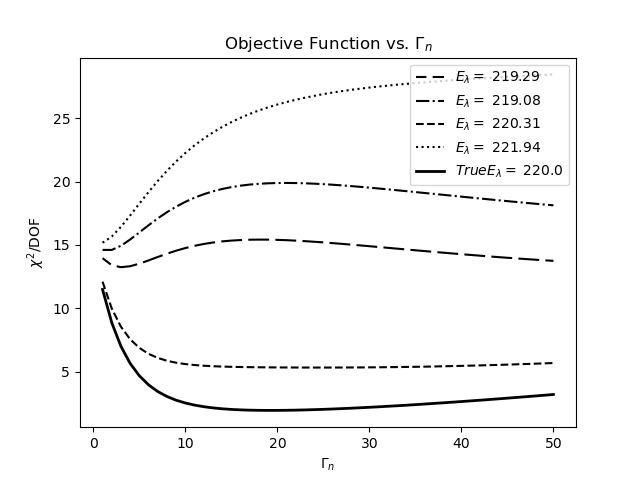

In [ ]:
iTrueE = np.argwhere(Elam==220.0).item()

markers = [(5, (10, 3)), 'dashdot', 'dashed','dotted']
figure()
for i, iE in enumerate([iTrueE-4,iTrueE-5,iTrueE+2,iTrueE+10]): #range(len(Elam)): #
    plot(G, chi2_map[iE, :], linestyle= markers[i], color='k', label=r'$E_{\lambda}=$ '+f'{np.round(Elam[iE],2)}')
plot(G, chi2_map[iTrueE, :], lw=2, color='k',label=r'$True E_{\lambda}=$ '+f'{np.round(Elam[iTrueE],2)}')
# yscale('log')
# xscale('log')
legend(loc="upper right")
xlabel(r"$\Gamma_n$")
# xlabel(r"$\Gamma_{\gamma}$")
ylabel(r'$\chi^2$/DOF')
# xlabel(r"\Gamma_n")
title(r"Objective Function vs. $\Gamma_n$")
# title(r"Objective Function vs. $\Gamma_{\gamma}$")
# xlim(-1,60)
# ylim(14.5,15.5)


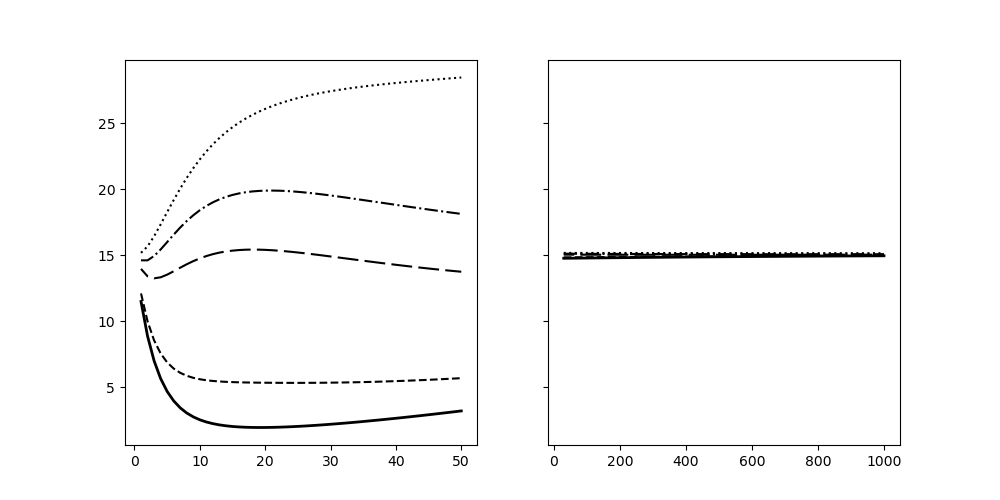

In [ ]:
iTrueE = np.argwhere(Elam==220.0).item()
# Gg = G
# chi2_map_Gg = chi2_map

markers = [(5, (10, 3)), 'dashdot', 'dashed','dotted']
fig, axes = subplots(1,2, figsize=(10,5), sharey=True)


for i, iE in enumerate([iTrueE-4,iTrueE-5,iTrueE+2,iTrueE+10]): #range(len(Elam)): #
    axes[1].plot(Gg, chi2_map_Gg[iE, :], linestyle= markers[i], color='k', label=r'$E_{\lambda}=$ '+f'{np.round(Elam[iE],2)}')
axes[1].plot(Gg, chi2_map_Gg[iTrueE, :], lw=2, color='k',label=r'$True E_{\lambda}=$ '+f'{np.round(Elam[iTrueE],2)}')

# yscale('log')
# # xscale('log')
# legend(loc="upper right")
# xlabel(r"$\Gamma_n$")
# # xlabel(r"$\Gamma_{\gamma}$")
# ylabel(r'$\chi^2$/DOF')
# # xlabel(r"\Gamma_n")
# title(r"Objective Function vs. $\Gamma_n$")
# # title(r"Objective Function vs. $\Gamma_{\gamma}$")
# # xlim(-1,60)
# ylim(14.5,15.5)

for i, iE in enumerate([iTrueE-4,iTrueE-5,iTrueE+2,iTrueE+10]): #range(len(Elam)): #
    axes[0].plot(G, chi2_map[iE, :], linestyle= markers[i], color='k', label=r'$E_{\lambda}=$ '+f'{np.round(Elam[iE],2)}')
axes[0].plot(G, chi2_map[iTrueE, :], lw=2, color='k',label=r'$True E_{\lambda}=$ '+f'{np.round(Elam[iTrueE],2)}')


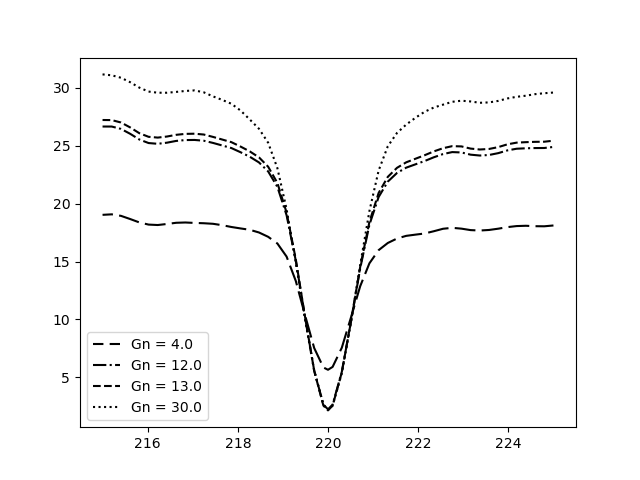

In [ ]:


figure()
for i, ig in enumerate([3, 11, 12, 29]): #[3, 9, 11, 12, 19]:
    plot(Elam, chi2_map[:, ig],linestyle= markers[i], color='k', label=f'{width} = {np.round(G[ig])}')
# plot(Elam, chi2_map[], lw=2, color='k',label=f"True Gn = {np.round(G[ig],2)}")
legend()

In [ ]:
import numpy as np

def gls_regression(X, y, W):
    """
    Generalized Least Squares (GLS) regression.

    Parameters:
    - X: Design matrix
    - y: Response variable
    - W: Weight matrix (inverse of the covariance matrix of errors)

    Returns:
    - Beta: GLS regression coefficients
    """
    XTWX_inv = np.linalg.inv(X.T @ W @ X)
    Beta = XTWX_inv @ X.T @ W @ y
    return Beta

# Example usage:
# Assuming X, y, and W are defined elsewhere
# For example, replace these lines with your actual data
X = np.random.rand(100, 3)
y = np.random.rand(100)
W = np.linalg.inv(np.diag(np.ones(100)))  # Identity matrix as an example

beta_gls = gls_regression(X, y, W)
print("GLS Coefficients:", beta_gls)


GLS Coefficients: [0.45632123 0.09108055 0.43302892]


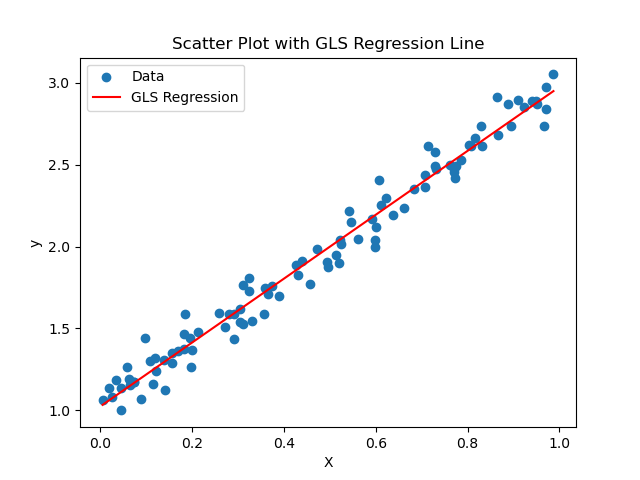

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 * X.squeeze() + 1 + 0.1 * np.random.randn(100)  # Example linear relationship with noise

# Design matrix
X_design = np.column_stack((np.ones_like(X), X))

# Weight matrix (assuming homoscedastic errors for simplicity)
W = np.linalg.inv(np.eye(len(X)))

# GLS regression
beta_gls = np.linalg.inv(X_design.T @ W @ X_design) @ X_design.T @ W @ y

figure()
# Scatter plot of the data
scatter(X, y, label='Data')

# Plot the GLS regression line
x_range = np.linspace(X.min(), X.max(), 100)
X_range_design = np.column_stack((np.ones_like(x_range), x_range))
y_gls = X_range_design @ beta_gls
plot(x_range, y_gls, color='red', label='GLS Regression')

xlabel('X')
ylabel('y')
legend()
title('Scatter Plot with GLS Regression Line')
show()
